# 카메라 스티커앱 만들기

## 1. 기본준비

- 데이터 준비

- 필요한 라이브러리/모듈 임포트

- 데이터 경로와 연결하기

In [32]:
# 라이브러리 / 모듈 준비

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import glob

### 디렉터리 생성 및 연결

In [2]:
!mkdir -p ~/aiffel/camera_sticker/models

In [3]:
!mkdir -p ~/aiffel/camera_sticker/images

In [4]:
!ln -s ~/data/* ~/aiffel/camera_sticker/images

ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/hero.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/image.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/king.png': File exists


In [11]:
!pwd

/aiffel/aiffel/camera_sticker


### opencv로 이미지 데이터 준비

exp 학습 예제

```
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()
```

In [18]:
img_dir_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/'

In [38]:
glob.glob(img_dir_path+'*')

['/aiffel/aiffel/camera_sticker/images/selfie02.png',
 '/aiffel/aiffel/camera_sticker/images/selfie05.png',
 '/aiffel/aiffel/camera_sticker/images/cat-whiskers.png',
 '/aiffel/aiffel/camera_sticker/images/selfie01.png',
 '/aiffel/aiffel/camera_sticker/images/image.png',
 '/aiffel/aiffel/camera_sticker/images/selfie04.png',
 '/aiffel/aiffel/camera_sticker/images/king.png',
 '/aiffel/aiffel/camera_sticker/images/selfie03.png',
 '/aiffel/aiffel/camera_sticker/images/hero.png']

In [190]:
selfy = [i for i in glob.glob(img_dir_path+'*') if 'self' in i]

In [191]:
# 여러 각도의 사진을 이용해 테스트 하게 될 예정이니 
# 이미지의 경로를 리스트로 뽑아두면 편하지 않을까?
selfy.sort()
selfy

['/aiffel/aiffel/camera_sticker/images/selfie01.png',
 '/aiffel/aiffel/camera_sticker/images/selfie02.png',
 '/aiffel/aiffel/camera_sticker/images/selfie03.png',
 '/aiffel/aiffel/camera_sticker/images/selfie04.png',
 '/aiffel/aiffel/camera_sticker/images/selfie05.png']

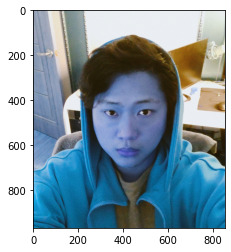

In [102]:
#일단 한 장 확인해보자. 귀신인가..?
selfy1 = cv2.imread(selfy[0])
img_show = selfy1.copy()
plt.imshow(selfy1)
plt.show()

In [46]:
#불러올 때마다 바꾸자면 귀찮을테니..?
#불러고오 rgb로 컨버트까지 해주는 메서드가 있을 것 같아서 찾아보았으나 실패.
#그러니 배운걸 써먹어보자.

def readncvt(img):
    img = cv2.imread(img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img_rgb

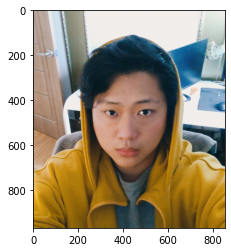

In [119]:
#성공! 근데 귀신인게 나을지도..

selfy1 = readncvt(selfy[0])
img_show = selfy1.copy()
plt.imshow(selfy1)
plt.show()

## 2. 얼굴 검출

### HOG와 SVM을 이용한 face detector

무슨 말인지 도통 모르겠다. 면접을 준비하며 선형변환의 개념을 이해하려 애쓰던 기억이 났을 따름.. 일단 모델을 받아보자.

### 얼굴을 찾아보자

In [104]:
selfy_rgb_1 = readncvt(selfy[0])
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(selfy_rgb_1, 1) # 두 번째 인자는 이미지 피라미드의 수(..) 라고한다

rectangles[[(277, 384) (598, 705)]]


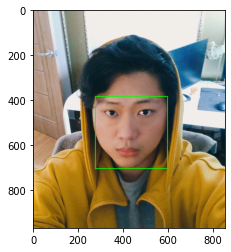

In [105]:
print(dlib_rects)


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    # 좌측상단과 우측하단 꼭지점을 기준으로 선을 그어주는 것 같다.
    # 선 색상, 굵기 인자를 입력해 줄 수 있는 듯하다.

plt.imshow(img_show)
plt.show()

## 3. 얼굴 랜드마크

? Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

### Dlib에서 weight flie 받고 압축풀기

In [2]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2022-01-11 03:23:19--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M   637KB/s    in 1m 57s  

2022-01-11 03:25:15 (536 KB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [3]:
!mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models

In [6]:
!bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

In [72]:
# landmark모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [106]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(selfy_rgb_1, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # (x,y)의 직관적 형태로 저장한다. 고 한다.. 원래는 어떤 형태이지?
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


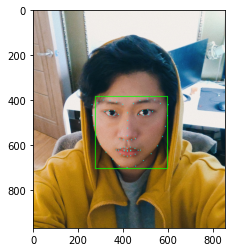

In [108]:
# 점이 조금 작은데..? 일단 첫 사진이니 진행해보자.
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

plt.imshow(img_show)
plt.show()

## 4. 스티커 적용하기

### 고양이 수염 스티커를 먼저 살펴보기

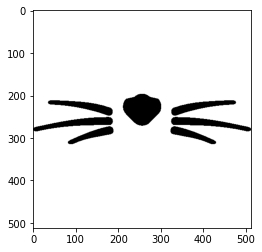

In [109]:
# 대략 이미지의 중심을 코 끝에 맞춰주면 될 것 같다.
sticker_path = img_dir_path+'cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
plt.show()

### 코의 index은 30이라고 하는데, 위치를 보자

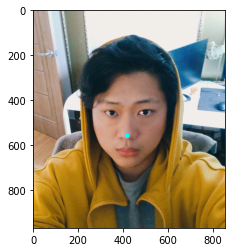

In [122]:
# 위치가 적절(?)하다.
img_show = selfy1.copy() # selfy1의 복사본을 새로 가져오지 않으면 계속 그림을 덧그린다.
point = list_landmarks[0][30]
cv2.circle(img_show, point, 10, (0, 255, 255), -1)

plt.imshow(img_show)
plt.show()

In [76]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] # 스티커 위치를
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(419, 559)
(x,y) : (419,398)
(w,h) : (322,322)


 [0],[1]이 순간 이해가 안되어 오래 고민했다.
대체로 잘 모르겠을 때는 print, type가 도움이 된다..
 
 > x = landmark[30][0]
 >
 > y = landmark[30][1]

In [125]:
# 왜 정사각형이지!?
print(dlib_rect.width())
print(dlib_rect.height())

322
322


아래 출력 결과에서 나는 분명 width값에 1.2를 곱해줬는데 자꾸 y의 크기가 커져서 이상했다. 출력 결과 원하던 대로 가로 길이가 길어진 것을 보고 그제야 2차원 배열의 형태에 대해서 떠올릴 수 있었다. 이 부분을 주지하는 것은 너무 어려운 일이다.

In [132]:
sticker_path = img_dir_path+'cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
print(img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (int(w*1.2), h))
#고양이 수염이니 폭은 박스 크기보다 조금 큰 것이 좋지 않을까? 1.2배 ㄱㄱ
print(img_sticker.shape)

(512, 512, 3)
(322, 386, 3)


In [170]:
refined_x = x - int(w*1.2/2) #폭을 늘렸으니 시작 좌표도 비율 만큼 더 옮겨주기
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (226,398)


In [174]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

반전된? 스티커가 출력되어 where 함수를 찾아보았다.
where메서드의 개념은 간단했지만... 적용은 어려웠다.

아무튼 단색이니 단순하게
img_sticker의 조건을 0이 아닐 때로 수정하니 정상적으로 출력되었는데,
원본 이미지의 배열과 관련 있어 보이지만 정확히는 모르겠다.

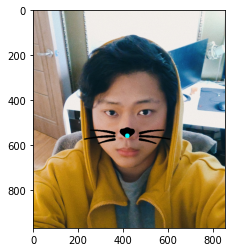

In [175]:


#정확한 조준(?)을 위해 아까 찍어본 코 인덱스 좌표를 겹쳐서 표기해 보았다. 성공!
point = list_landmarks[0][30]
cv2.circle(img_show, point, 10, (0, 255, 255), -1)
plt.imshow(img_show)
plt.show()

### 최종 출력

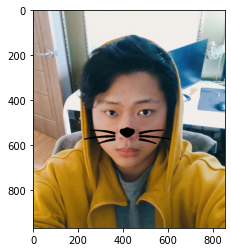

In [176]:
img_show = selfy1.copy()

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(img_show)
plt.show()

## 5. 문제점 찾아보기

### 우선 제시된 문제에 대해 답을 달아보자

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
>face detection에 의해 정의된 기준 좌표(실습의 경우 dlib.rectangles)가 변화하는 비율에 따라 스티커의 벡터(?)가 계산되어야 할 것 같다.

- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
>- 멀리서: 고화질의 이미지라면 검출 가능할 수 있겠지만, sliding window의 계산 영역이 너무 커지지 않을까?
>- 옆으로: histogram으로 출력한 결과가 얼굴 형태임을 인지하기 어려울 것 같다. 만약 디텍팅에 성공하더라도 이목구비의 구분은 내장된 랜드마크에 의해 구분되니 너무 복집해질 것 같다. 심지어 스티커까지 계산해야한다면.. 흠..

- 실행 속도가 중요할까요?
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
>실행 상황과 사용 목적을 고려할 때 정확도 보다 실행 속도가 중요할 것 같다.

### 여러 사진들로 시험해보기

In [235]:
# 셀피 분신술..
selfy = [i for i in glob.glob(img_dir_path+'*') if 'self' in i]
selfy.sort()
selfy

['/aiffel/aiffel/camera_sticker/images/selfie01.png',
 '/aiffel/aiffel/camera_sticker/images/selfie02.png',
 '/aiffel/aiffel/camera_sticker/images/selfie03.png',
 '/aiffel/aiffel/camera_sticker/images/selfie04.png',
 '/aiffel/aiffel/camera_sticker/images/selfie05.png']

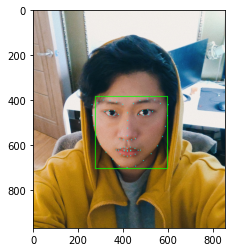

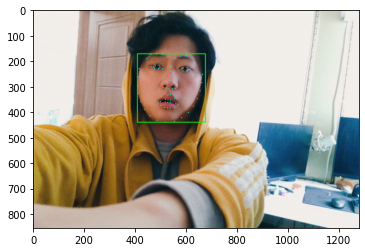

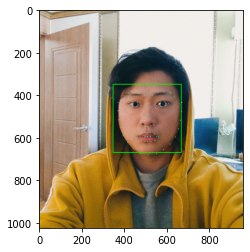

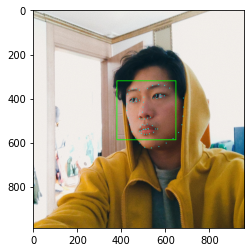

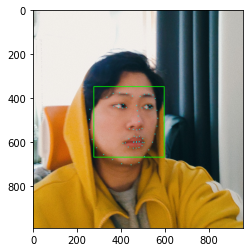

In [236]:
i=0
for selfy in selfy:
    cat_selfy = readncvt(selfy)
    img_show = cat_selfy.copy()    
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(cat_selfy, 1)
    list_landmarks = []
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
        points = landmark_predictor(cat_selfy, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
            
        for point in list_landmarks[0]:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            
        plt.imshow(img_show)
        plt.show()


### 급 마무리

우선 랜드마크를 찍고 보니..

- 스티커를 회전시켜 주어야 한다.
> 최소 두 개의 점(고양이 스티커는 양쪽 콧볼아래가 좋을 것 같음)을 기준으로 이미지를 기울여주어야 할 것 같다.

- 스티커의 비율도 조절 되어야 한다.
> 사각형을 벗어난 랜드마크와 안쪽으로 몰린 랜드마크의 좌표(0,1,15,16이 적당해 보임)를 활용하면 계산이 가능은 해 보이지만.. 자신도 없거니와 시간상 주객전도가 될 것 같다.

그리고 무엇보다..  <i>계속 내 얼굴을 보는게 너무 괴로워<i/>

## 5. 마치며

### 기억에 남는 학습 내용
> 폭을 늘이기 위해 계산을 했는데 자꾸 y좌표가 커져서 당황했고, shape을 확인한 결과 [1]번째 배열이 길어진 것을 보고 나름 원리를 파악한 순간이 인상적이었다.


### 어려웠던 점
- 대부분 원리를 잘 모르는 라이브러리/모듈을 사용해 조금 답답했다


### 추가로 해보고 싶은 점
- 바로 위에 나열한 부분을 언젠가는 해결 해보고 싶다.
- 시계열 데이터에 큰 관심은 없지만 훌륭한 라이브러리가 많으니 간단한 사물인식 ai구현 프로젝트는 재미있을 것도 같다.


### 총평
: 비슷한 프로젝트가 또 있을지 모르겠지만, 그냥 연예인 사진이라도 가져와서 하는 것이 정신건강에 크게 이로울 것 같다는 생각이 많이 들었다.
개강 이후 쭉 빡빡한 일정에 쫓겼는데 그래도 조금 코드가 익숙해지는 느낌이 들어서 좋다.

